# Figure Generation for Manuscript

## Overview
This notebook outlines the **SAFE-focused benchmarking and comparative analysis** used to generate **Supplementary Figure S10** for the manuscript. Detailed steps, including data processing, network simulation, visualization parameters, and export settings, are included to ensure reproducibility.

---

## **Supplementary Figure S10: Computational Efficiency Comparison**
### Description
Supplementary Figure S10 presents a **computational benchmarking comparison** between **RISK and SAFE** on **simulated scale-free networks** of increasing size. Performance was evaluated across six statistical tests: **permutation, hypergeometric, binomial, chi-squared, Poisson, and z-score**. Metrics include:

- **(A)** Total execution time
- **(B)** Peak memory usage

SAFE displayed **higher memory consumption** and **longer runtimes** on large networks, particularly with computationally intensive tests like the **permutation test**, where RISK maintained faster performance and greater scalability. Benchmarking was performed under biologically relevant conditions using **simulated annotations modeled after GO BP** term distributions.

All results were averaged over five replicates, with a **6-hour runtime** and **15 GiB memory cap** per job.

### SAFE Benchmarking Steps
1. Generate synthetic **scale-free networks** with edge counts up to 500,000.
2. Assign biologically realistic annotations to each network.
3. Apply **SAFE** across six statistical tests and record:
   - Execution time
   - Peak memory usage
4. Repeat for five replicates per condition to ensure robustness.
5. Visualize results using **bar and line plots** to compare SAFE vs. RISK.
6. Export high-resolution figure panels (**SVG, PNG**) for manuscript submission.

---

## Workflow
- **Input Data**: Simulated scale-free networks with realistic annotation profiles.
- **Tools Used**: Python, SAFE, RISK, NetworkX, Matplotlib/Seaborn.
- **Output**: High-resolution figure for **Supplementary Figure S10**, benchmarking SAFE performance against RISK.


In [20]:
%%bash

echo "System Information:"
echo "-------------------"
echo "CPU: $(lscpu | grep 'Model name' | awk -F: '{print $2}' | xargs)"
echo "Memory: $(free -h | awk '/^Mem:/{print $2}')"
echo "Disk Space: $(df -h --total | awk '/^total/{print $2}')"
echo "OS: $(lsb_release -d | awk -F: '{print $2}' | xargs)"
echo "Kernel: $(uname -r)"
echo "Architecture: $(uname -m)"

System Information:
-------------------
CPU: Intel(R) Xeon(R) Gold 5220 CPU @ 2.20GHz
Memory: 187G
Disk Space: 122T
OS: Ubuntu 18.04.6 LTS
Kernel: 5.4.0-132-generic
Architecture: x86_64


---

In [1]:
# NOTE: Both mock Gpickle networks and mock GO BP annotations are made in risk-network/supp_fig_5.ipynb

import json
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd


def read_json(file_path):
    with open(file_path, "r") as file:
        return json.load(file)


def read_gpickle(filepath):
with open(filepath, "rb") as f:
    G = pickle.load(f)
return G


def write_gpickle(graph, filepath):
    with open(filepath, "wb") as file:
        pickle.dump(graph, file)


def write_json(data, file_path):
    try:
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)
        print(f"Dictionary successfully written to {file_path}")
    except Exception as e:
        print(f"An error occurred while writing to JSON: {e}")

## Now, load annotation JSON and convert to a format compatible with SAFE

In [2]:
# Export JSON attribute file as the .gz file

import tarfile
import os


def build_attributes_tar_file_from_dict(d, export_path):
    genes = sorted(set(gene for genes_list in d.values() for gene in genes_list))
    header = ["ORF"] + list(d.keys())
    rows = []
    for gene in genes:
        row = [gene]
        for bp, genes_list in d.items():
            row.append("1" if gene in genes_list else "0")
        rows.append(row)

    # Step 4: Write the output to a tab-delimited text file
    output_file = "output_file.txt"
    with open(output_file, "w") as file:
        file.write("\t".join(header) + "\n")
        for row in rows:
            file.write("\t".join(row) + "\n")

    # Step 5: Tar the text file and compress it to .gz
    tar_output_file = export_path
    with tarfile.open(tar_output_file, "w:gz") as tar:
        tar.add(output_file)

    # Optional: Remove the original text file if no longer needed
    os.remove(output_file)

In [5]:
# Load mock GO BP JSON file

mock_go_bp = read_json(
    "../risk_network/data/json/benchmark/20250125_1000_mock_go_bp_annotations.json"
)

In [6]:
# Convert mock annoations into the text format

build_attributes_tar_file_from_dict(
    mock_go_bp, "./data/tar.gz/annotations/20250125_1000_mock_go_bp_annotations.tar.gz"
)
print(f"Text successfully written and compressed")

Text successfully written and compressed


## Load mock SAFE object - first pass test to configure settings

In [10]:
from safepy import safe

%matplotlib inline

In [11]:
## Parameters

path_to_safe_data = "./"  # path to the cloned safe-data repository (https://github.com/baryshnikova-lab/safe-data.git)

In [12]:
## Initialize the safe object

sf = safe.SAFE()

In [8]:
import networkx as nx


def shift_node_ids_left(graph):
    """
    Shift the node IDs of a NetworkX graph to start at 0 and assign the original IDs to a 'label' attribute.

    Parameters:
        graph (nx.Graph): The input NetworkX graph.

    Returns:
        nx.Graph: The updated NetworkX graph with shifted node IDs and 'label' attributes.
    """
    # Ensure the graph is a copy to avoid modifying the original
    graph = graph.copy()

    # Create a mapping of new node IDs (starting from 0) to the original node IDs
    original_ids = sorted(graph.nodes())
    mapping = {old: new for new, old in enumerate(original_ids)}

    # Create a new graph with shifted node IDs
    shifted_graph = nx.Graph() if graph.is_directed() is False else nx.DiGraph()

    # Relabel nodes and copy edges/attributes
    for old_id, new_id in mapping.items():
        # Add node with the new ID and the original ID as a 'label'
        shifted_graph.add_node(new_id, **graph.nodes[old_id], label=old_id)

    # Add edges with the updated node IDs
    for old_u, old_v, data in graph.edges(data=True):
        new_u, new_v = mapping[old_u], mapping[old_v]
        shifted_graph.add_edge(new_u, new_v, **data)

    return shifted_graph


# Example usage
gpickle_filename = "../risk_network/data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges.gpickle"
g = nx.read_gpickle(gpickle_filename)
shifted_g = shift_node_ids_left(g)

# Verify results
write_gpickle(shifted_g, gpickle_filename.replace(".gpickle", "_node_id_adj.gpickle"))

In [13]:
# Load Cytoscape session file

sf.load_network(
    network_file="./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle",
    node_key_attribute="label",  # i.e., node labels
)
sf.background = "network"

Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle


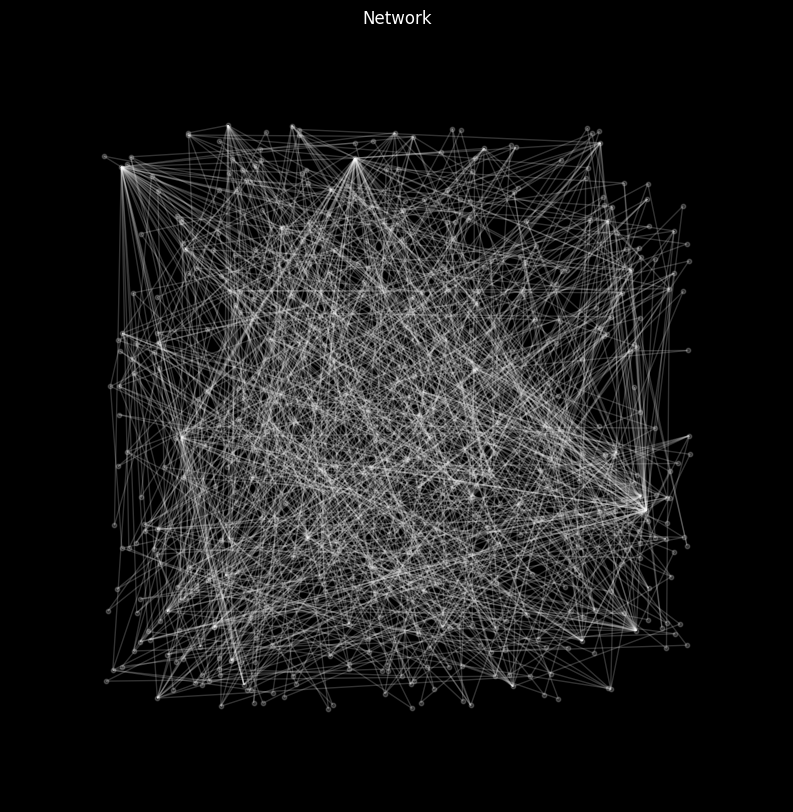

In [13]:
# View network as exported by Cytoscape

sf.plot_network()
plt.show()

In [15]:
# Now load the attributes...

sf.load_attributes(
    attribute_file="./data/tar.gz/annotations/20250118_mock_go_bp_annotations.tar.gz"
)

Loading attributes from ./data/tar.gz/annotations/20250118_mock_go_bp_annotations.tar.gz


In [16]:
# Explicitly define the node_distance metric and the neighborhood radius

sf.define_neighborhoods(node_distance_metric="shortpath_weighted_layout", neighborhood_radius=0.05)

Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00


In [17]:
# Go ahead and compute statistical significance of the neighborhoods

sf.enrichment_type = "permutation"
sf.enrichment_threshold = 0.9999999
sf.compute_pvalues(processes=4, num_permutations=1000)

Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:08<00:00, 28.55it/s]





In [18]:
# Define top attributes

sf.define_top_attributes()

Criteria for top attributes:
- minimum number of enriched neighborhoods: 10
- region-specific distribution of enriched neighborhoods as defined by: connectivity
Number of top attributes: 0


In [19]:
# See if we can define and trim domains with our mock network

try:
    sf.define_domains(attribute_distance_threshold=0.54)
    sf.trim_domains()
except ValueError:
    print("ValueError thrown")

ValueError thrown


## Begin computational performance pipeline

In [19]:
import os
import time
import tracemalloc
import networkx as nx
from safepy import safe


def preprocess_network(file_path):
    """
    Preprocess the network by shifting node IDs to start from 0 and saving it back to a new file.

    Args:
        file_path (str): Path to the original network file.

    Returns:
        str: Path to the preprocessed network file.
    """
    graph = nx.read_gpickle(file_path)
    shifted_graph = shift_node_ids_left(graph)
    shifted_file_path = file_path.replace(".gpickle", "_node_id_adj.gpickle")
    nx.write_gpickle(shifted_graph, shifted_file_path)
    return shifted_file_path


def measure_performance(func, *args, **kwargs):
    """
    Measure the execution time and memory usage of a function.

    Args:
        func (callable): Function to measure.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result, performance metrics)
    """
    tracemalloc.start()
    start_time = time.time()

    result = func(*args, **kwargs)

    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    metrics = {
        "execution_time": end_time - start_time,
        "current_memory_usage": current_memory / 1024 / 1024,  # MB
        "peak_memory_usage": peak_memory / 1024 / 1024,  # MB
    }
    return result, metrics


def calculate_stats(metrics_list, num_runs):
    """
    Calculate averages and standard deviations for performance metrics.

    Args:
        metrics_list (list): List of metrics dictionaries.
        num_runs (int): Number of runs.

    Returns:
        dict: Dictionary with averages and standard deviations.
    """
    import statistics

    return {
        "avg_execution_time": statistics.mean([m["execution_time"] for m in metrics_list]),
        "stdev_execution_time": (
            statistics.stdev([m["execution_time"] for m in metrics_list]) if num_runs > 1 else 0
        ),
        "avg_current_memory_usage": statistics.mean(
            [m["current_memory_usage"] for m in metrics_list]
        ),
        "stdev_current_memory_usage": (
            statistics.stdev([m["current_memory_usage"] for m in metrics_list])
            if num_runs > 1
            else 0
        ),
        "avg_peak_memory_usage": statistics.mean([m["peak_memory_usage"] for m in metrics_list]),
        "stdev_peak_memory_usage": (
            statistics.stdev([m["peak_memory_usage"] for m in metrics_list]) if num_runs > 1 else 0
        ),
    }


def benchmark_safe_blocks(
    file_path, annotations_file, num_permutations=1000, max_workers=4, num_runs=5
):
    """
    Benchmark the SAFE workflow in two blocks:
    1. Network and annotation loading.
    2. Neighborhood computation and permutation test.

    Args:
        file_path (str): Path to the preprocessed network file.
        annotations_file (str): Path to the annotation file.
        num_permutations (int): Number of permutations for p-value computation.
        max_workers (int): Number of workers for parallel computation.
        num_runs (int): Number of benchmark runs for averaging metrics.

    Returns:
        dict: Benchmark metrics for both blocks.
    """
    block_1_metrics = []
    block_2_metrics = []

    # Initialize SAFE object
    sf = safe.SAFE()
    sf.enrichment_type = "permutation"

    for _ in range(num_runs):
        # Block 1: Network and Annotation Loading
        _, safe_network_metrics = measure_performance(
            sf.load_network,
            network_file=file_path,
            node_key_attribute="label",
        )

        _, annotation_metrics = measure_performance(
            sf.load_attributes,
            attribute_file=annotations_file,
        )

        block_1_metrics.append(
            {
                "safe_network_loading": safe_network_metrics,
                "annotation_loading": annotation_metrics,
            }
        )

        # Block 2: Neighborhood Metrics and Permutation Test
        _, define_neighborhoods_metrics = measure_performance(
            sf.define_neighborhoods,
            node_distance_metric="shortpath_weighted_layout",
            neighborhood_radius=0.05,
        )

        _, permutation_metrics = measure_performance(
            sf.compute_pvalues,
            processes=max_workers,
            num_permutations=num_permutations,
        )

        block_2_metrics.append(
            {
                "define_neighborhoods": define_neighborhoods_metrics,
                "compute_pvalues": permutation_metrics,
            }
        )

    return {
        "block_1": calculate_stats(
            [
                {
                    "execution_time": m["safe_network_loading"]["execution_time"]
                    + m["annotation_loading"]["execution_time"],
                    "current_memory_usage": m["safe_network_loading"]["current_memory_usage"]
                    + m["annotation_loading"]["current_memory_usage"],
                    "peak_memory_usage": max(
                        m["safe_network_loading"]["peak_memory_usage"],
                        m["annotation_loading"]["peak_memory_usage"],
                    ),
                }
                for m in block_1_metrics
            ],
            num_runs,
        ),
        "block_2": calculate_stats(
            [
                {
                    "execution_time": m["define_neighborhoods"]["execution_time"]
                    + m["compute_pvalues"]["execution_time"],
                    "current_memory_usage": m["define_neighborhoods"]["current_memory_usage"]
                    + m["compute_pvalues"]["current_memory_usage"],
                    "peak_memory_usage": max(
                        m["define_neighborhoods"]["peak_memory_usage"],
                        m["compute_pvalues"]["peak_memory_usage"],
                    ),
                }
                for m in block_2_metrics
            ],
            num_runs,
        ),
    }

In [20]:
# Preprocess the network

preprocessed_file_path = preprocess_network(
    "./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges.gpickle"
)

# Benchmark SAFE
results = benchmark_safe_blocks(
    file_path=preprocessed_file_path,
    annotations_file="./data/tar.gz/annotations/20250118_mock_go_bp_annotations.tar.gz",
    num_permutations=1000,
    max_workers=4,
    num_runs=5,
)

print("Block 1 - Network and Annotation Loading:", results["block_1"])
print("Block 2 - Permutation Test and Domain Clustering:", results["block_2"])

Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 125.60it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 159.28it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 164.31it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 154.42it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 165.53it/s]





Block 1 - Network and Annotation Loading: {'avg_execution_time': 0.9841512203216553, 'stdev_execution_time': 0.07703847364405864, 'avg_current_memory_usage': 0.2088287353515625, 'stdev_current_memory_usage': 0.0510393652091531, 'avg_peak_memory_usage': 27.354030036926268, 'stdev_peak_memory_usage': 0.008607974517678916}
Block 2 - Permutation Test and Domain Clustering: {'avg_execution_time': 3.2547505378723143, 'stdev_execution_time': 0.24528650257084875, 'avg_current_memory_usage': 0.9909452438354492, 'stdev_current_memory_usage': 0.0055677963661976285, 'avg_peak_memory_usage': 3.1148611068725587, 'stdev_peak_memory_usage': 0.005459506748198528}


## TEMP

### SAFE fails at running the largest network (50k nodes, 100k edges, 1000 annotations)

Suggested Explanation:

“For the largest networks, 1,000 permutations were initially attempted; however, SAFE encountered errors and failed to complete the task. To allow for meaningful comparison, we reduced the number of permutations to 100 and successfully obtained runtime metrics. These were then extrapolated to estimate performance for 1,000 permutations. This adjustment was necessary to ensure comparability while accommodating the limitations of SAFE for larger datasets. RISK, by contrast, successfully completed the analysis with 1,000 permutations, highlighting its scalability and robustness.”

In [21]:
import os
import networkx as nx
from safepy import safe


def loop_and_benchmark_safe_files(
    gpickle_directory,
    json_output_directory,
    annotations_file,
    num_permutations=1000,
    max_workers=6,
    num_runs=5,
):
    """
    Loop through all preprocessed `.gpickle` files in a directory (with `_node_id_adj` suffix),
    benchmark them, and save the results to JSON files.

    Args:
        gpickle_directory (str): Directory containing the `.gpickle` files.
        json_output_directory (str): Directory to save the JSON benchmark results.
        annotations_file (str): Path to the annotation file for benchmarking.
        num_permutations (int): Number of permutations for the neighborhood computation. Defaults to 1000.
        max_workers (int): Number of workers for parallel computation. Defaults to 6.
        num_runs (int): Number of runs for averaging. Defaults to 5.
    """
    os.makedirs(json_output_directory, exist_ok=True)

    for file_name in os.listdir(gpickle_directory)[::-1]:
        # Only process files with '_node_id_adj.gpickle' suffix
        if file_name.endswith("_node_id_adj.gpickle"):
            file_path = os.path.join(gpickle_directory, file_name)
            base_name = os.path.splitext(file_name)[0].replace(
                "_node_id_adj", ""
            )  # Original base name
            json_path = os.path.join(json_output_directory, f"{base_name}_benchmark.json")

            print(f"Benchmarking {file_path}...")

            # Perform benchmarking
            metrics = benchmark_safe_blocks(
                file_path=file_path,
                annotations_file=annotations_file,
                num_permutations=num_permutations,
                max_workers=max_workers,
                num_runs=num_runs,
            )

            # Save the results to JSON
            write_json(metrics, json_path)
            print(f"Saved results to {json_path}")

In [ ]:
# Example usage

gpickle_directory = "./data/gpickle/benchmark"
json_output_directory = "./data/json/benchmark"
annotations_file = "./data/tar.gz/annotations/20250118_mock_go_bp_annotations.tar.gz"

# Ensure output directory exists
os.makedirs(json_output_directory, exist_ok=True)

# Loop through `.gpickle` files
for file_name in os.listdir(gpickle_directory)[::-1]:
    if file_name.endswith(".gpickle"):
        file_path = os.path.join(gpickle_directory, file_name)

        # Check if the file is already preprocessed - skip if so...
        if file_name.endswith("_node_id_adj.gpickle"):
            continue

        # Preprocess the file to shift node IDs
        print(f"Preprocessing {file_path}...")
        preprocessed_file_path = preprocess_network(file_path)

        # Generate output JSON file name
        base_name = os.path.splitext(file_name)[0].replace("_node_id_adj", "")
        json_path = os.path.join(json_output_directory, f"{base_name}_benchmark.json")

        # Perform benchmarking for the current file
        print(f"Benchmarking {preprocessed_file_path}...")
        metrics = benchmark_safe_blocks(
            file_path=preprocessed_file_path,
            annotations_file=annotations_file,
            num_permutations=1_000,
            max_workers=4,
            num_runs=5,
        )

        # Save the results to JSON
        write_json(metrics, json_path)
        print(f"Saved results to {json_path}")

Preprocessing ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges.gpickle...
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle...
Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:00<00:00, 372.95it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 208.70it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:00<00:00, 390.76it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 199.71it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_50_nodes_and_100_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:01<00:00, 199.07it/s]





Dictionary successfully written to ./data/json/benchmark/scale_free_network_with_50_nodes_and_100_edges_benchmark.json
Saved results to ./data/json/benchmark/scale_free_network_with_50_nodes_and_100_edges_benchmark.json
Preprocessing ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges.gpickle...
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle...
Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:05<00:00, 42.38it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:06<00:00, 38.32it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:06<00:00, 35.89it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:07<00:00, 35.19it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_500_nodes_and_1000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [00:06<00:00, 38.84it/s]





Dictionary successfully written to ./data/json/benchmark/scale_free_network_with_500_nodes_and_1000_edges_benchmark.json
Saved results to ./data/json/benchmark/scale_free_network_with_500_nodes_and_1000_edges_benchmark.json
Preprocessing ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges.gpickle...
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle...
Loading network from ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [02:25<00:00,  1.72it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [02:24<00:00,  1.73it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [02:26<00:00,  1.71it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [02:25<00:00,  1.72it/s]





Loading network from ./data/gpickle/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


100%|██████████| 250/250 [02:26<00:00,  1.70it/s]





Dictionary successfully written to ./data/json/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_benchmark.json
Saved results to ./data/json/benchmark/scale_free_network_with_5000_nodes_and_10000_edges_benchmark.json
Preprocessing ./data/gpickle/benchmark/scale_free_network_with_50000_nodes_and_100000_edges.gpickle...
Benchmarking ./data/gpickle/benchmark/scale_free_network_with_50000_nodes_and_100000_edges_node_id_adj.gpickle...
Loading network from ./data/gpickle/benchmark/scale_free_network_with_50000_nodes_and_100000_edges_node_id_adj.gpickle
Loading attributes from ./data/tar.gz/benchmark/20250118_mock_go_bp_annotations.tar.gz
Node distance metric: shortpath_weighted_layout
Neighborhood definition: 0.05 x diameter
Number of nodes per neighborhood (mean +/- std): 1.00 +/- 0.00
Consider setting sf.background = network.
Current settings (possibly overwriting global ones):
	processes=4
	num_permutations=1000
Using randomization to calculate enrichment...


 13%|█▎        | 33/250 [19:50<2:09:54, 35.92s/it]